In [ ]:
results_path = 'Results/'

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.6.0
(3030, 176)


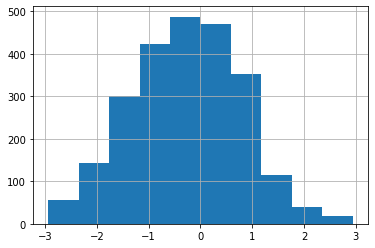

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import pickle

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import pickle
from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

from scipy.stats import pearsonr

S_tensor = pd.read_csv("Data/Sampling_tensor.csv", index_col=0, header=None)
line_names = pd.Series(S_tensor.index)

data = pd.read_csv("Data/10pctimpx_forJZ.csv")
print(data.shape)
data = data[np.array(data['LineType'] == "RIL") | np.array(data['LineType'] == "RIAIL") | np.array(data['LineType'] == "G0")]
num_nas = np.isnan(data.iloc[:, 7:].to_numpy()).sum(1)
# plt.hist(num_nas)
# plt.show()

data = data[num_nas < 169] # filter all lines without genotype info
geno_all = data.iloc[:, 7:].to_numpy()
n, L = geno_all.shape

par_dict = dict(zip(['G0', 'P530', 'P563'], line_names[:3]))

Line_new = []
for row in range(data.shape[0]):
    linetype = data.iloc[row].LineType
    line_num = data.iloc[row]['Linex']
    if (linetype != "RIL")  and (linetype != "RIAIL" ):
        Line_new.append(par_dict[linetype])
    else:
        if linetype == "RIL":
            Line_new.append(linetype + "_" + str(line_num - 200))
        else: Line_new.append(linetype + "_" + str(line_num))
data.Linex = Line_new

set(line_names).difference(set(data.Linex.unique())) ## Line names are the same in the genotype file and phenotype file

from scipy.sparse import coo_matrix
# Generate A matrix for mapping geno to geno_expand
line2num = dict(zip(line_names, range(len(line_names))))
row_idx, col_idx = np.arange(len(data)), np.array([line2num[line] for line in data.Linex])
A = coo_matrix((np.ones(len(row_idx)), (row_idx, col_idx)))
A = A.toarray()
# Turn block to dummy variables
data.block = data.block.astype("str")
block = pd.get_dummies(data.block).to_numpy()

y = data.ln_ci
y.hist()
plt.show()

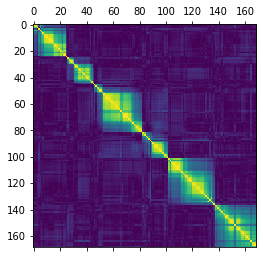

In [4]:
# Genotype correlations

G = S_tensor[:].to_numpy()

G_cov = np.matmul((G - G.mean(0)).T, (G - G.mean(0)))/len(G)

G_cor = G_cov/np.outer(G.std(0), G.std(0).T)

plt.matshow(np.abs(G_cor))
plt.show()

### Haplo genotypes

#### Identify haplo groups

In [5]:
import numpy as np

def one_hot_encode(labels, num_classes):
    num_labels = len(labels)
    one_hot = np.zeros((num_labels, num_classes))
    one_hot[np.arange(num_labels), labels] = 1
    return one_hot

In [6]:
# Greedy algorithm for identifying haplo groups

g = 0
haplos = [0]
for i in range(1, 169):
    if pearsonr(G[:, i], G[:, i-1])[0]**2 > .8:
        haplos.append(g)
    else: 
        g += 1
        haplos.append(g)

hap_site_counts = []
for i in set(haplos):
    count = np.sum(np.array(haplos) == i)
    hap_site_counts.append(count)
hap_site_counts = np.array(hap_site_counts)

print(len(set(haplos)))

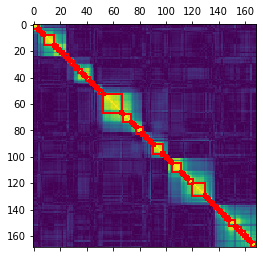

In [7]:
from matplotlib import patches

def draw_rec(start_pos, end_pos):
    # Define the top-left and bottom-right coordinates of the rectangle
    top_left = (start_pos, start_pos)  # (row, column)
    bottom_right = (end_pos, end_pos)  # (row, column)

    # Get the dimensions of each cell
    cell_width = 1
    cell_height = 1

    # Calculate the coordinates of the rectangle
    x = top_left[1] - 0.5  # Adjust the x-coordinate to the center of the top-left cell
    y = top_left[0] - 0.5  # Adjust the y-coordinate to the center of the top-left cell
    width = (bottom_right[1] - top_left[1] + 1) * cell_width
    height = (bottom_right[0] - top_left[0] + 1) * cell_height

    # Draw the rectangle
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)
    

# Genotype correlations
G = S_tensor[:].to_numpy()

G_cov = np.matmul((G - G.mean(0)).T, (G - G.mean(0)))/len(G)

G_cor = G_cov/np.outer(G.std(0), G.std(0).T)

plt.matshow(np.abs(G_cor))

for i in range(len(hap_site_counts)):
    start_pos = hap_site_counts[:i].sum()
    end_pos = hap_site_counts[:i + 1].sum()

    draw_rec(start_pos, end_pos)

plt.show()

#### Assign haplotypes

In [64]:
# Set MA530 to be the reference genotype 
g_ref = S_tensor.iloc[1].to_numpy()

In [66]:
def assign_haplo(g):
    c = np.array(haplos) == g
    diff = G[:, c] - g_ref[c]
    d = (diff*diff).sum(1)/np.sum(c)
    return d < .5

In [67]:
G_hap = [assign_haplo(g) for g in set(haplos)]
G_hap = np.array(G_hap).T

In [68]:
haplos_ref = []

for g in set(haplos):
    haplos_ref.append(g_ref[np.array(haplos) == g])

#### Check haplotype reconstruction accuracy

In [12]:
def retrieve_g(hap):
    g = []
    for i in range(len(hap)):
        genotype = g_ref[np.array(haplos) == i]
        if hap[i]:
            g.append(list(genotype))
        else:
            g.append(list((genotype - 1)%2))
    g = sum(g, [])
    return g

G_re = [retrieve_g(G_hap[i]) for i in range(len(G_hap))]

G_re = np.array(G_re)

diff = G[G % 1 == 0.] - G_re[G % 1 == 0.]

print(f"proprotion of wrong alleles = {np.sum(np.abs(diff))/len(diff)}" )

proprotion of wrong alleles = 0.01321230812364197


#### Build haplotype design matrix

In [13]:
k = 0

HapX = {}

for h in set(haplos):
    positions = (np.array(haplos) == h)
    if positions.sum() > 1:
        if len(set(g_ref[positions])) == 1:
            if g_ref[positions][0] == 1:
                HapX[h] = (1*G_hap[:, h])[:, np.newaxis]
            else: HapX[h] = ((1*G_hap[:, h] - 1) % 2)[:, np.newaxis]
        else: HapX[h] = one_hot_encode(1 * G_hap[:, h], 2)
    
    else: 
        k += 1
        pos = np.where(np.array(haplos) == h)[0][0]
        HapX[h] = G[:, pos][:, np.newaxis]

In [14]:
HapX = np.concatenate(list(HapX.values()), 1)
HapX = HapX.round()

#### Define mutant haplotypes

In [70]:
haplo_positions = []
haplo_types = []
haplo_type_parent__ = []
for h in set(haplos):
    matches = (np.array(haplos) == h)
    positions = np.where(matches)[0]
    if matches.sum() > 1: # if linkage group contains more than 1 site
        if len(set(g_ref[positions])) == 1: # if mutations are in complete positive linkage
            haplo_positions.append(positions)
            if g_ref[positions][0] == 1:
                haplo_types.append(haplos_ref[h])
                haplo_type_parent__.append("MA530")
            else: 
                haplo_types.append((haplos_ref[h] - 1) % 2)
                haplo_type_parent__.append("MA563")
            
        else: # if mutations are in negative linkage
            haplo_positions.append(positions)
            haplo_types.append(haplos_ref[h])
            haplo_type_parent__.append("MA530")
            haplo_positions.append(positions)
            haplo_types.append((haplos_ref[h] - 1) % 2)
            haplo_type_parent__.append("MA563")            
    else: 
        haplo_positions.append(positions)
        haplo_types.append([1])
        if g_ref[positions] == 1.:
            haplo_type_parent__.append('MA530')
        else: haplo_type_parent__.append('MA563')

In [71]:
haplo_type_parent = []

for h in set(haplos):
    matches = (np.array(haplos) == h)
    positions = np.where(matches)[0]
    if matches.sum() > 1:
        if len(set(g_ref[positions])) == 1:
            if g_ref[positions][0] == 1:
                haplo_type_parent.append('MA530')
            else: haplo_type_parent.append('MA563')
        else: 
            haplo_type_parent.append('MA530')
            haplo_type_parent.append('MA563')
    
    else: 
        if g_ref[positions] == 1:
            haplo_type_parent.append('MA530')
        else: haplo_type_parent.append('MA563')

In [72]:
haplo_type_parent_ = []

for h in haplos_ref:
    if list(set(h)) == [1.]:
        haplo_type_parent_.append('MA530')
    elif list(set(h)) == [0.]:
        haplo_type_parent_.append('MA563')
    else:
        haplo_type_parent_.append('MA530')
        haplo_type_parent_.append('MA563')

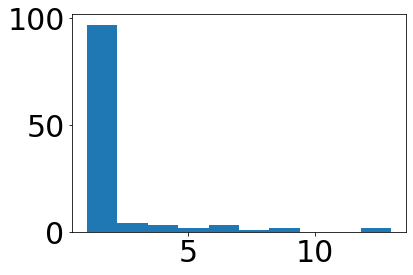

In [79]:
plt.hist([len(s) for s in haplo_positions], bins=10)
plt.show()

#### Name haplo mutant types

In [33]:
haplo_muts = []
haplo_muts.append('1_mut1')
i = 1
for j in range(1, len(haplo_positions)):
    if list(haplo_positions[j]) == list(haplo_positions[j-1]):
        haplo_muts.append(str(i) + "_mut2")
    else: 
        i += 1
        haplo_muts.append(str(i) + "_mut1")

haplo_positions_s = [", ".join([str(_ + 1) for _ in (list(h))]) for h in haplo_positions]

haplo_info = pd.DataFrame({"Mutant Haplotype": haplo_muts, "Loci": haplo_positions_s, "Parent": haplo_type_parent_})

haplo_info.to_csv(
    results_path + 'Mutant_haplotypes_table.csv', index=None)

In [34]:
haplo_info

,Mutant Haplotype,Loci,Parent
0,1_mut1,"1, 2, 3",MA530
1,2_mut1,4,MA530
2,3_mut1,5,MA563
3,4_mut1,6,MA530
4,5_mut1,7,MA563
...,...,...,...
109,100_mut1,164,MA530
110,101_mut1,165,MA530
111,102_mut1,"166, 167, 168",MA530
112,102_mut2,"166, 167, 168",MA563


### Mutant haplotype effects

#### Get haplo effect traces

In [37]:
with open(results_path + "traces_geno_mut.pkl", 'rb') as f:
    traces_mut_all_types = pickle.load(f)

In [39]:
linetypes = ['all', 'RIL', 'RIAIL']

hap_data_all = {}

for linetype in linetypes:

    traces_mut = traces_mut_all_types[linetype]

    traces_hap = []
    for i in range(len(haplo_positions)):
        if len(haplo_positions[i]) == 1:
            traces_hap.append(traces_mut[:, haplo_positions[i]].flatten())
        else:
            if len(set(haplo_types[i])) == 1:
                traces_hap.append(traces_mut[:, haplo_positions[i]].sum(1).flatten())
            else:
                # weights = (np.array(haplo_types[i]) - 1) % 2
                weights = np.array(haplo_types[i])
                traces_hap.append(np.matmul(traces_mut[:, haplo_positions[i]], weights).flatten())

    traces_hap = np.stack(traces_hap, 1)
    
    plotdata = pd.DataFrame({'mean': np.mean(traces_hap, 0), 
                            'CI2.5%': np.quantile(traces_hap, .025, 0), 
                            'CI97.5%': np.quantile(traces_hap, .975, 0)})  
    plotdata = plotdata.rename(dict(zip(range(len(haplo_muts)), haplo_muts)))
    plotdata = plotdata.rename_axis('Mutant haplotype')
    hap_data_all[linetype] = plotdata

#### Export summary table

In [40]:
for key in hap_data_all.keys():
    df = hap_data_all[key]
    if key == 'all':
        name = 'RIL+RIAIL'
    else: name = key

    df.to_csv(results_path + "Table_posterior_haplotype_effects_" + name + ".csv")

#### Plot mutant haplotype effects

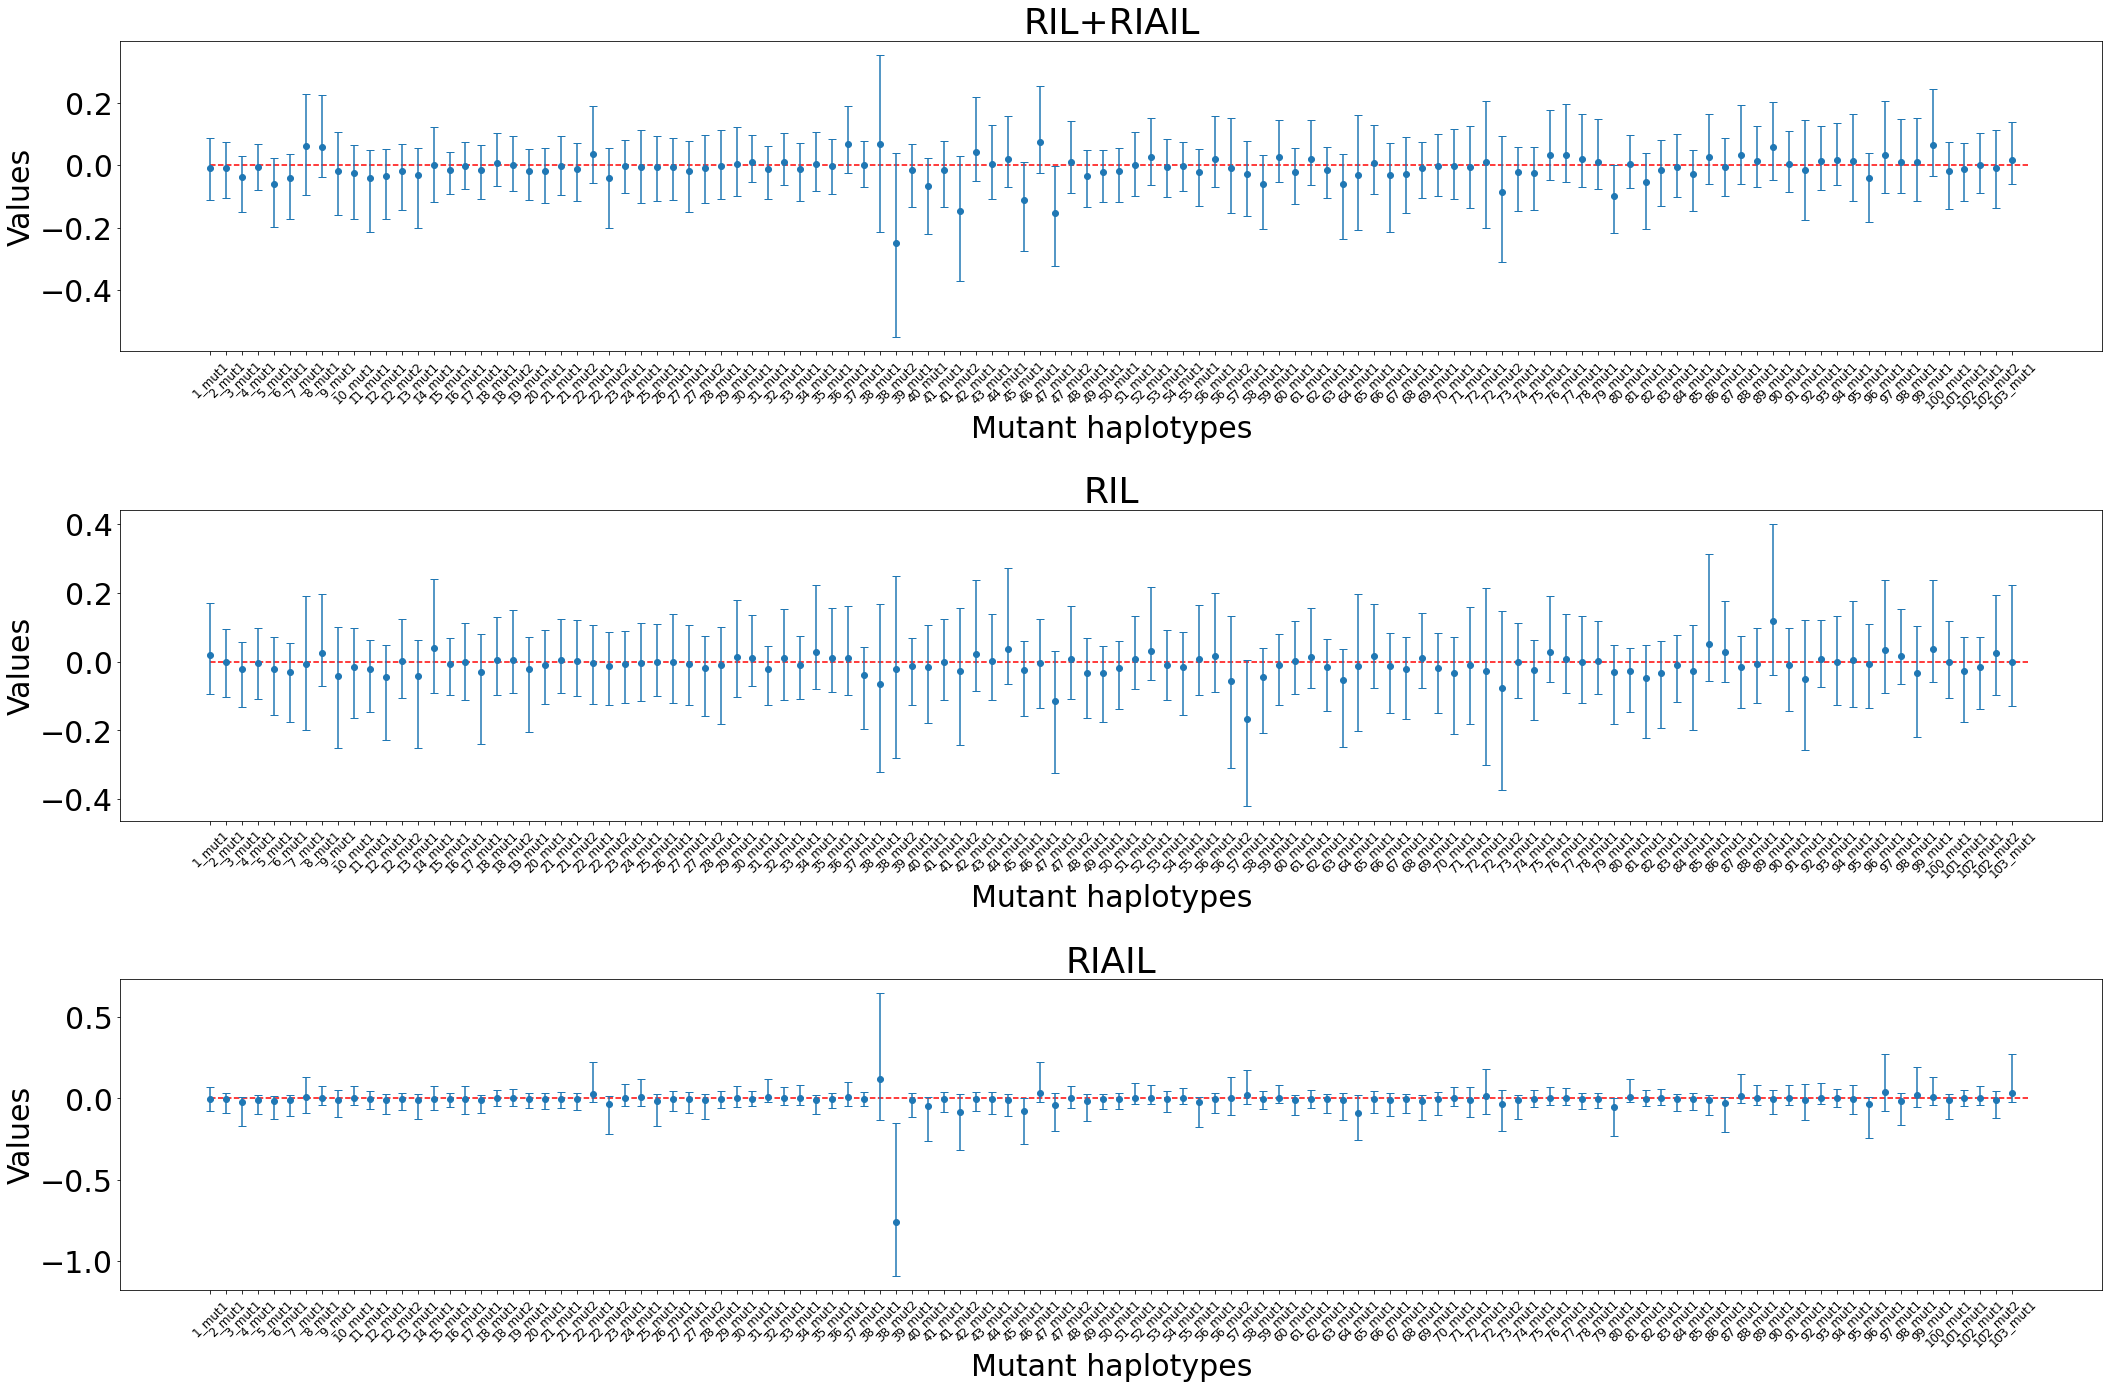

In [81]:
plt.rcParams['font.size'] = 30
fig, ax = plt.subplots(3, 1, figsize=(30, 20), layout='tight')

for i, linetype in enumerate(linetypes):
    if linetype == 'all':
        name = 'RIL+RIAIL'
    else: name = linetype
    
    plotdata = hap_data_all[linetype]
    # Plot 

    ax[i].hlines(y=0, xmin=0, xmax=114, linestyles='dashed', color='r')
    ax[i].errorbar(x=haplo_muts, y=plotdata['mean'], 
                 yerr=(plotdata['mean'] - plotdata['CI2.5%'], plotdata['CI97.5%'] - plotdata['mean']), 
                 capsize=4, fmt='o')


    ax[i].set_ylabel('Values')
    ax[i].set_xlabel('Mutant haplotypes')
    ax[i].set_title(name)
    ax[i].set_xticks(np.arange(114))    
    ax[i].set_xticklabels(plotdata.index, rotation=45, fontsize=12)  # Set the labels and rotate them by 45 degrees

plt.savefig(results_path + 'Figure_posterior_haplotype_effects.pdf')

plt.show()

In [82]:
hap_data_all['RIAIL']['mean'].min()

-0.7579981693399206

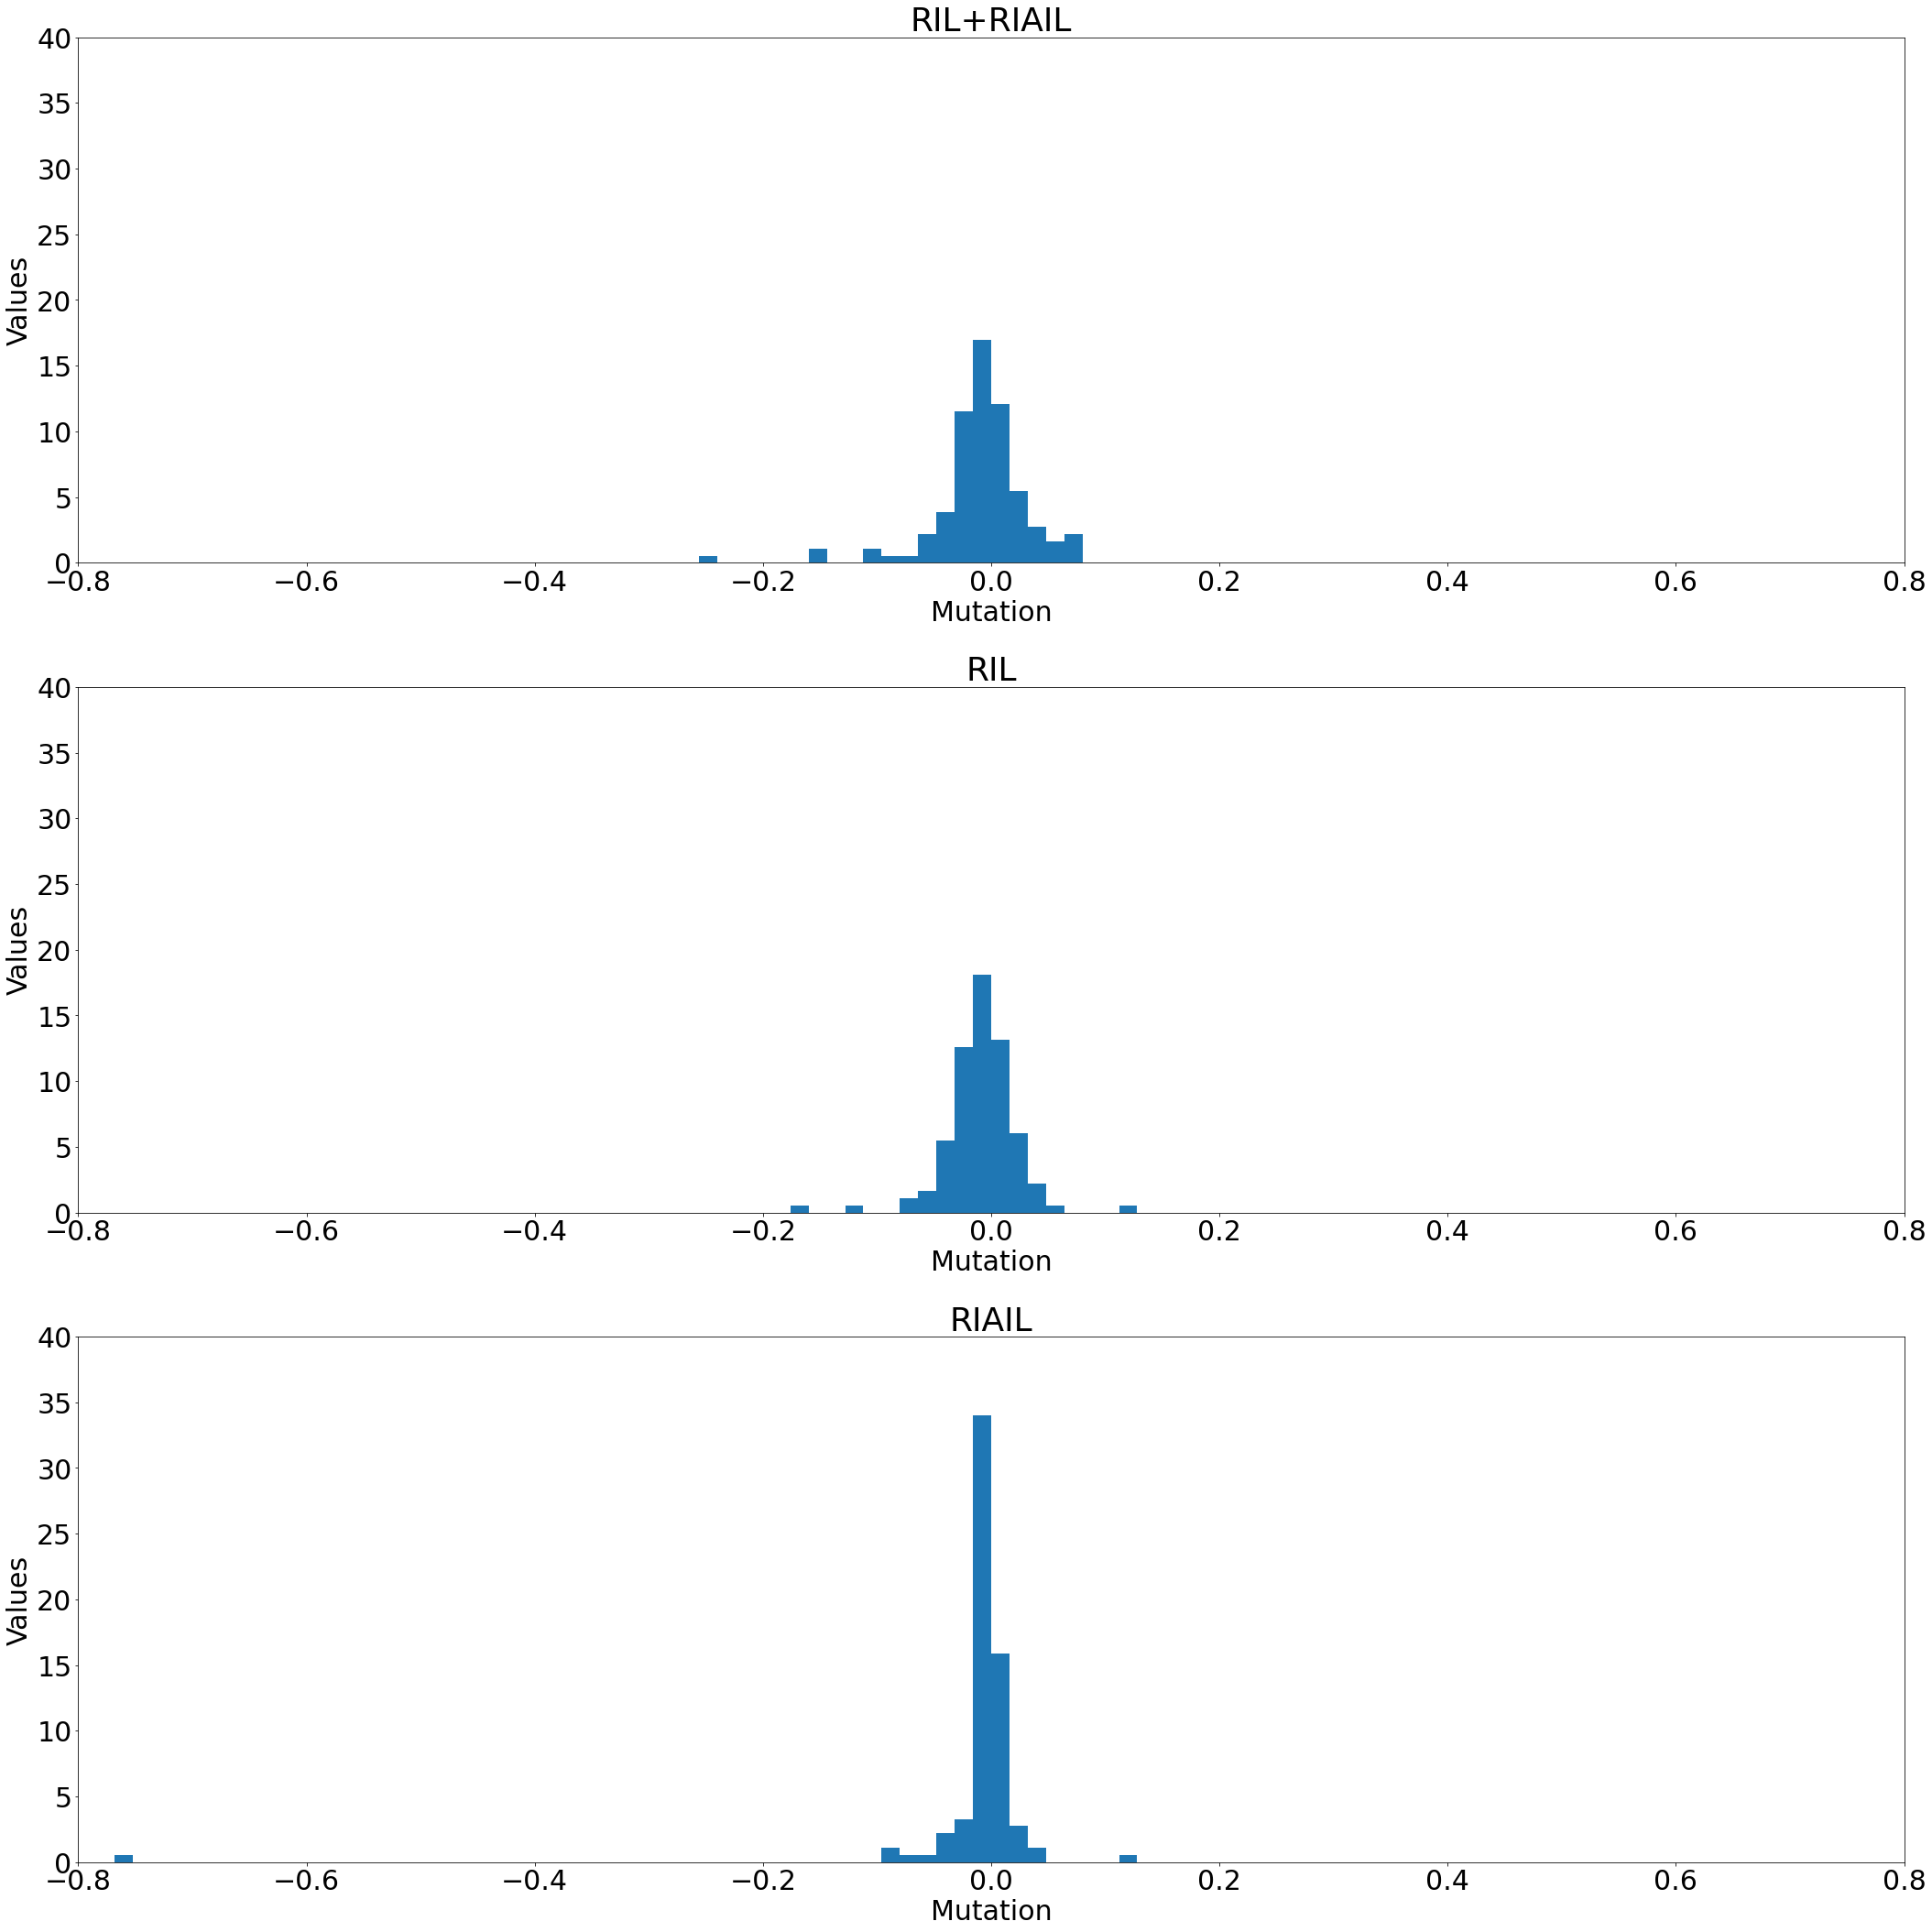

In [83]:
plt.rcParams['font.size'] = 30
fig, ax = plt.subplots(3, 1, figsize=(30, 30), layout='tight')

interval = [-.8, .8]
bin_edges = np.linspace(*interval, 101)  # Define 20 bins

for i, linetype in enumerate(linetypes):
    if linetype == 'all':
        name = 'RIL+RIAIL'
    else: name = linetype
    
    plotdata = hap_data_all[linetype]
    ax[i].hist(plotdata['mean'], density=True, bins=bin_edges)

    ax[i].set_ylabel('Values')
    ax[i].set_xlabel('Mutation')
    ax[i].set_title(name)
    ax[i].set_xlim(*interval)
    ax[i].set_ylim([0, 40])

plt.savefig(results_path + 'Figure_hist_posterior_haplotype_effects.pdf')
plt.show() 